## Changed Model archietecter from two dense 

Test 1
global avg -> dropout ->dens(27)
image flop only horizontoal 
Network trained unstable way. Val_loss and accuraccy fluctuated.
Test 47%

Test 2
image flip horizontal vertical
global avg -> dropout ->dens(27)
Test 34%

Test 3
image flop only horizontoal 
global avg -> batchnorm ->dens(27)
end in 7 Test 51% --> 44%

Test 4
image flip horizontal vertical
global avg -> batchnorm ->dens(27)
35%?

Test 5
image flip horizontal 
global avg -> dense(512)-> dropout(0.5) ->dense(27)
test 60%

Test 6
image flip horizontal vertical
global avg -> dense(512)-> dropout(0.5) ->dense(27)
test 46%

Test 7
Full retrain based on imagenet weight
image flip horizontal 
global avg -> dense(512)-> dropout(0.5) ->dense(27)
test 80%

In [22]:
!pip install -U git+https://github.com/qubvel/efficientnet.git



  Cloning https://github.com/qubvel/efficientnet.git to /tmp/pip-req-build-2h6028xm
  Running command git clone -q https://github.com/qubvel/efficientnet.git /tmp/pip-req-build-2h6028xm
     |████████████████████████████████| 26.3MB 4.9MB/s eta 0:00:01��█████████████▏              | 14.1MB 4.9MB/s eta 0:00:03
     |████████████████████████████████| 3.3MB 34.8MB/s eta 0:00:01
     |████████████████████████████████| 4.4MB 31.9MB/s eta 0:00:01
     |████████████████████████████████| 1.8MB 33.1MB/s eta 0:00:01
  Stored in directory: /tmp/pip-ephem-wheel-cache-0ggza_da/wheels/14/68/e6/d061b0945ee935f204eade26004c24087ef2d56d5388f4cdb7
  Stored in directory: /root/.cache/pip/wheels/de/63/64/3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af
Successfully built efficientnet networkx


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()
tf.__version__

'1.14.0'

In [2]:
import pandas as pd

train_df = pd.read_pickle('./mvc_train.pkl')
test_df = pd.read_pickle('./mvc_test.pkl')

In [3]:
train_df.sample(10)

,filename,attributes
81384,category/Shirts_Tops/p8578783_s3278735_v2.jpg,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, ..."
40259,category/Sweaters/p8649540_s3440298_v1.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
107464,category/Shirts_Tops/p8623220_s3372706_v1.jpg,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
25026,category/Coats_Outerwear/p8675474_s3496229_v5.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
66646,category/Jeans/p8602699_s3325715_v0.jpg,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
57939,category/Coats_Outerwear/p8555332_s3224882_v3.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
60603,category/Shirts_Tops/p8391040_s2855216_v3.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
79920,category/Shirts_Tops/p8283252_s2590740_v3.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
87518,category/Sweaters/p8666690_s3476276_v0.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
99735,category/Sweaters/p8593792_s3306817_v1.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


In [4]:
label = ['BoardShorts',
'ButtonUpShirts',
'Crew',
'Denim',
'FloralPrint',
'GraphicPrint',
'Halter',
'Hood',
'HorizontalStripes',
'Insulated',
'Leggings',
'LongSleeves',
'Mesh',
'Plaid',
'Polos',
'Scoop',
'ShortSleeves',
'Sleeveless',
'SnowPants',
'Stripes',
'VerticalStripes',
'Vests',
'Vneck',
'Zipper',
'halfZip',
'quarter3Zip',
'quarterZip']

In [5]:
IMG_SIZE = 256
CROP_SIZE = 224

def train_preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    #image = (image/127.5) - 1
    image = tf.image.random_crop(image, [CROP_SIZE, CROP_SIZE, 3])
    #image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.per_image_standardization(image)    
    #image /= 255.0  # normalize to [0,1] range
    image -= [0.485 * 255, 0.456 * 255, 0.406 * 255]
    image /= [0.229 * 255, 0.224 * 255, 0.225 * 255]    

    #encoded_png_io = io.BytesIO(encoded_png)
    #image = pil.open(encoded_png_io)
    #image = np.asarray(image)    

    return image

def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [CROP_SIZE, CROP_SIZE])
    #image = tf.image.per_image_standardization(image)
    image -= [0.485 * 255, 0.456 * 255, 0.406 * 255]
    image /= [0.229 * 255, 0.224 * 255, 0.225 * 255]

    #image = tf.image.random_crop(image, [CROP_SIZE, CROP_SIZE, 3])
    #image = (image/127.5) - 1
    #image /= 255.0  # normalize to [0,1] range
    

    #encoded_png_io = io.BytesIO(encoded_png)
    #image = pil.open(encoded_png_io)
    #image = np.asarray(image)    

    return image

In [6]:
def train_load_and_preprocess_image(path):
    image = tf.read_file(path)
    return train_preprocess_image(image)

def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

In [7]:
import numpy as np
train_paths = train_df['filename'].tolist()
train_label = np.asarray(train_df['attributes'].tolist())

test_paths = test_df['filename'].tolist()
test_label = np.asarray(test_df['attributes'].tolist())

In [8]:
train_path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
test_path_ds = tf.data.Dataset.from_tensor_slices(test_paths)

train_image_ds = train_path_ds.map(train_load_and_preprocess_image)
test_image_ds = test_path_ds.map(load_and_preprocess_image)

In [9]:
train_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_label, tf.int32))
test_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_label, tf.int32))

In [10]:
train_image_label_ds = tf.data.Dataset.zip((train_image_ds, train_label_ds))
print(train_image_label_ds)
test_image_label_ds = tf.data.Dataset.zip((test_image_ds, test_label_ds))
print(test_image_label_ds)

<DatasetV1Adapter shapes: ((224, 224, 3), (27,)), types: (tf.float32, tf.int32)>
<DatasetV1Adapter shapes: ((224, 224, 3), (27,)), types: (tf.float32, tf.int32)>


In [11]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.

train_image_label_ds = train_image_label_ds.shuffle(buffer_size=512).repeat()
train_image_label_ds = train_image_label_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
train_image_label_ds

<DatasetV1Adapter shapes: ((?, 224, 224, 3), (?, 27)), types: (tf.float32, tf.int32)>

In [12]:
test_image_label_ds = test_image_label_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_image_label_ds

<DatasetV1Adapter shapes: ((?, 224, 224, 3), (?, 27)), types: (tf.float32, tf.int32)>

In [13]:
for image_batch, label_batch in train_image_label_ds:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 27)


In [14]:
from efficientnet.tfkeras import EfficientNetB3
IMG_SHAPE = (CROP_SIZE, CROP_SIZE, 3)

base_model = EfficientNetB3(input_shape=IMG_SHAPE, include_top=False,weights='imagenet')

W0724 15:33:07.296710 140074420549440 deprecation.py:573] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/deprecation.py:507: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with distribution=normal is deprecated and will be removed in a future version.
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


43917312/43917040 [==============================] - 2s 0us/step


In [15]:
#with tf.device('/cpu:0'): 
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1536)


In [16]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.input_shape)

0 [(None, 224, 224, 3)]
1 (None, 224, 224, 3)
2 (None, 112, 112, 40)
3 (None, 112, 112, 40)
4 (None, 112, 112, 40)
5 (None, 112, 112, 40)
6 (None, 112, 112, 40)
7 (None, 112, 112, 40)
8 (None, 40)
9 (None, 1, 1, 40)
10 (None, 1, 1, 10)
11 [(None, 112, 112, 40), (None, 1, 1, 40)]
12 (None, 112, 112, 40)
13 (None, 112, 112, 24)
14 (None, 112, 112, 24)
15 (None, 112, 112, 24)
16 (None, 112, 112, 24)
17 (None, 112, 112, 24)
18 (None, 24)
19 (None, 1, 1, 24)
20 (None, 1, 1, 6)
21 [(None, 112, 112, 24), (None, 1, 1, 24)]
22 (None, 112, 112, 24)
23 (None, 112, 112, 24)
24 (None, 112, 112, 24)
25 [(None, 112, 112, 24), (None, 112, 112, 24)]
26 (None, 112, 112, 24)
27 (None, 112, 112, 144)
28 (None, 112, 112, 144)
29 (None, 112, 112, 144)
30 (None, 56, 56, 144)
31 (None, 56, 56, 144)
32 (None, 56, 56, 144)
33 (None, 144)
34 (None, 1, 1, 144)
35 (None, 1, 1, 6)
36 [(None, 56, 56, 144), (None, 1, 1, 144)]
37 (None, 56, 56, 144)
38 (None, 56, 56, 32)
39 (None, 56, 56, 32)
40 (None, 56, 56, 192)
41

In [17]:
#with tf.device('/cpu:0'): 
#base_model.trainable = False

for layer in base_model.layers[:375]:
    layer.trainable = False
    
for layer in base_model.layers[375:]:
    layer.trainable = True

#base_model.trainable = True
base_model.summary()

Model: "efficientnet-b3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 40) 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 40) 0           stem_bn[0][0]                    
____________________________________________________________________________________

Total params: 10,783,528
Trainable params: 3,072
Non-trainable params: 10,780,456
__________________________________________________________________________________________________


In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
#dropout_layer = tf.keras.layers.Dropout(0.5)
#dropout_batch = dropout_layer(feature_batch_average)
#batchnorm_layer = tf.keras.layers.BatchNormalization()
#batchnorm = batchnorm_layer(feature_batch_average)
#print(batchnorm.shape)

In [19]:

mid_layer = tf.keras.layers.Dense(512, activation='relu')
mid_batch = mid_layer(feature_batch_average)
dropout_layer = tf.keras.layers.Dropout(0.5)
dropout_batch = dropout_layer(mid_batch)
#prediction_layer = tf.keras.layers.Dense(27, activation='sigmoid')
prediction_layer = tf.keras.layers.Dense(27)
prediction_batch = prediction_layer(dropout_batch)
print(prediction_batch.shape)

(32, 27)


In [20]:
nb_train_samples = len(train_paths) 
nb_val_samples = len(test_paths) 

steps_per_epoch = nb_train_samples // BATCH_SIZE
validation_steps=nb_val_samples//BATCH_SIZE
nb_val_samples

27348

In [21]:
def weighted_loss(target, prediction):
    batch = tf.shape(target)[0]
    
    #print(batch)
    target = tf.cast(target, tf.float32)
    weight = 1-tf.divide(tf.reduce_sum(target,0, keepdims=True),tf.cast(batch, tf.float32))
    #print(weight)
    #print(loss)
    return tf.nn.weighted_cross_entropy_with_logits(labels=target, logits=prediction, pos_weight=weight)
    
    #return tf.nn.weighted_cross_entropy_with_logits(targets=tf.cast(y, tf.float32), logits=y_, pos_weight=tf.cast(weight, tf.float32))

when val is very slow refer this [page](https://github.com/keras-team/keras/issues/6101)

In [22]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    mid_layer,
    dropout_layer,
    prediction_layer
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 7, 7, 1536)        10783528  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               786944    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 27)                13851     
Total params: 11,584,323
Trainable params: 803,867
Non-trainable params: 10,780,456
_________________________________________________________________


In [24]:
#parallel_model = multi_gpu_model(model, gpus=2)
callbacks = [
    # Interrupt training if `val_loss` stops improving for over 2 epochs
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    tf.keras.callbacks.ModelCheckpoint(filepath='./efficient3/finetune_aug.top.h5', save_best_only=True),
    # Write TensorBoard logs to `./logs` directory
    tf.keras.callbacks.TensorBoard(log_dir='./efficient3/logs')
]

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss=weighted_loss, optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy()])
#model.load_weights('./mobilev2_2019072004/weights')


In [25]:
history = model.fit(train_image_label_ds, steps_per_epoch=steps_per_epoch, epochs=20, validation_data=test_image_label_ds, validation_steps=validation_steps, \
          workers=4, use_multiprocessing=True , callbacks=callbacks)

Epoch 1/20
3418/3418 [==============================] - 1390s 407ms/step - loss: 0.1144 - binary_accuracy: 0.9536 - val_loss: 0.1608 - val_binary_accuracy: 0.9477
Epoch 2/20
3418/3418 [==============================] - 1376s 403ms/step - loss: 0.1035 - binary_accuracy: 0.9569 - val_loss: 0.1573 - val_binary_accuracy: 0.9471
Epoch 3/20
3418/3418 [==============================] - 1371s 401ms/step - loss: 0.1012 - binary_accuracy: 0.9577 - val_loss: 0.1577 - val_binary_accuracy: 0.9464
Epoch 4/20
3418/3418 [==============================] - 1373s 402ms/step - loss: 0.0998 - binary_accuracy: 0.9583 - val_loss: 0.1616 - val_binary_accuracy: 0.9470
Epoch 5/20
3418/3418 [==============================] - 1376s 402ms/step - loss: 0.0985 - binary_accuracy: 0.9587 - val_loss: 0.1563 - val_binary_accuracy: 0.9475
Epoch 6/20
3418/3418 [==============================] - 1376s 403ms/step - loss: 0.0978 - binary_accuracy: 0.9589 - val_loss: 0.1642 - val_binary_accuracy: 0.9461
Epoch 7/20
3418/3418 [

In [36]:
model.save('./efficient/finetune_aug.h5')

In [37]:
model.save_weights('./efficient/weights')

In [29]:
path='./rename/p8604244_s3328909_v0.jpg'
image = tf.read_file(path)
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.resize(image, [224,224])
#image = image/127.5 - 1 # normalize to [0,1] range
image = image/255
pred = model.predict(image[np.newaxis, ...])
indexes = np.where(pred[0,:]> 0.5)
attr=pd.Series(label)
attr.iloc[indexes]

Series([], dtype: object)

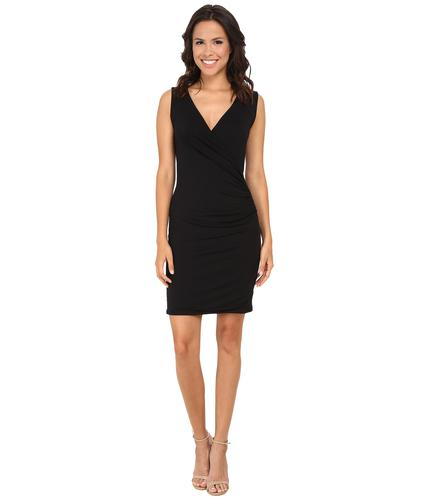

In [27]:
from IPython.display import Image
Image(path)

In [28]:
import matplotlib.pyplot as plt


acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')